In [1]:
import numpy as np
import autograd.numpy as anp      
import scipy, scipy.ndimage, scipy.sparse, scipy.sparse.linalg 

In [2]:
import matplotlib.pyplot as plt  
import gym
from gym import spaces
import random
import numpy as np
import autograd.numpy as anp  
from gym.utils import seeding

In [3]:
from hbaselines.algorithms import RLAlgorithm
from hbaselines.goal_conditioned.td3 import GoalConditionedPolicy

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_args(normals, forces, density=1e-4):  # Manage the problem setup parameters
    width = normals.shape[0] - 1
    height = normals.shape[1] - 1
    fixdofs = np.flatnonzero(normals.ravel())
    alldofs = np.arange(2 * (width + 1) * (height + 1))
    freedofs = np.sort(list(set(alldofs) - set(fixdofs)))
    params = {
      # material properties
      'young': 1, 'young_min': 1e-9, 'poisson': 0.3, 'g': 0,
      # constraints
      'density': density, 'xmin': 0.001, 'xmax': 1.0,
      # input parameters
      'nelx': width, 'nely': height, 'mask': 1, 'penal': 3.0, 'filter_width': 1,
      'freedofs': freedofs, 'fixdofs': fixdofs, 'forces': forces.ravel(),
      # optimization parameters
      'opt_steps': 80, 'print_every': 10}
    return ObjectView(params)

def mbb_beam(width=4, height=4, density=1e-4, y=1, x=0, rd=-1):  # textbook rl_beam example
    normals = np.zeros((width + 1, height + 1, 2))
    normals[0, 0, x] = 1
    normals[0, 0, y] = 1
    normals[0, -1, x] = 1
    normals[0, -1, y] = 1
    forces = np.zeros((width + 1, height + 1, 2))
    forces[-1, rd, y] = -1
    return normals, forces, density

def young_modulus(x, e_0, e_min, p=3):
    return e_min + x ** p * (e_0 - e_min)

def physical_density(x, args, volume_contraint=False, use_filter=True):
    x = args.mask * x.reshape(args.nely, args.nelx)  # reshape from 1D to 2D
    return gaussian_filter(x, args.filter_width) if use_filter else x  # maybe filter

def mean_density(x, args, volume_contraint=False, use_filter=True):
    return anp.mean(physical_density(x, args, volume_contraint, use_filter)) / anp.mean(args.mask)

def objective(x, args, volume_contraint=False, use_filter=True):
    kwargs = dict(penal=args.penal, e_min=args.young_min, e_0=args.young)
    x_phys = physical_density(x, args, volume_contraint=volume_contraint, use_filter=use_filter)
    ke     = get_stiffness_matrix(args.young, args.poisson)  # stiffness matrix
    u      = displace(x_phys, ke, args.forces, args.freedofs, args.fixdofs, **kwargs)
    c      = compliance(x_phys, u, ke, **kwargs)
    return c

def gaussian_filter(x, width): # 2D gaussian blur/filter
    return scipy.ndimage.gaussian_filter(x, width, mode='reflect')

def _gaussian_filter_vjp(ans, x, width): # gives the gradient of orig. function w.r.t. x
    del ans, x  # unused
    return lambda g: gaussian_filter(g, width)

def compliance(x_phys, u, ke, *, penal=3, e_min=1e-9, e_0=1):
    nely, nelx = x_phys.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords for the index map

    n1 = (nely+1)*(elx+0) + (ely+0)  # nodes
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    all_ixs = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    u_selected = u[all_ixs]  # select from u matrix

    ke_u = anp.einsum('ij,jkl->ikl', ke, u_selected)  # compute x^penal * U.T @ ke @ U
    ce = anp.einsum('ijk,ijk->jk', u_selected, ke_u)
    C = young_modulus(x_phys, e_0, e_min, p=penal) * ce.T
    return anp.sum(C)

def get_stiffness_matrix(e, nu):  # e=young's modulus, nu=poisson coefficient
    k = anp.array([1/2-nu/6, 1/8+nu/8, -1/4-nu/12, -1/8+3*nu/8,
                -1/4+nu/12, -1/8-nu/8, nu/6, 1/8-3*nu/8])
    return e/(1-nu**2)*anp.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                               [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                               [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                               [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                               [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                               [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                               [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                               [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]])
    
def get_k(stiffness, ke):
    # Constructs sparse stiffness matrix k (used in the displace fn)
    # First, get position of the nodes of each element in the stiffness matrix
    nely, nelx = stiffness.shape
    ely, elx = anp.meshgrid(range(nely), range(nelx))  # x, y coords
    ely, elx = ely.reshape(-1, 1), elx.reshape(-1, 1)

    n1 = (nely+1)*(elx+0) + (ely+0)
    n2 = (nely+1)*(elx+1) + (ely+0)
    n3 = (nely+1)*(elx+1) + (ely+1)
    n4 = (nely+1)*(elx+0) + (ely+1)
    edof = anp.array([2*n1, 2*n1+1, 2*n2, 2*n2+1, 2*n3, 2*n3+1, 2*n4, 2*n4+1])
    edof = edof.T[0]
    x_list = anp.repeat(edof, 8)  # flat list pointer of each node in an element
    y_list = anp.tile(edof, 8).flatten()  # flat list pointer of each node in elem

    # make the global stiffness matrix K
    kd = stiffness.T.reshape(nelx*nely, 1, 1)
    value_list = (kd * anp.tile(ke, kd.shape)).flatten()
    return value_list, y_list, x_list

def displace(x_phys, ke, forces, freedofs, fixdofs, *, penal=3, e_min=1e-9, e_0=1):
    # Displaces the load x using finite element techniques (solve_coo=most of runtime)
    stiffness = young_modulus(x_phys, e_0, e_min, p=penal)
    k_entries, k_ylist, k_xlist = get_k(stiffness, ke)

    index_map, keep, indices = _get_dof_indices(freedofs, fixdofs, k_ylist, k_xlist)

    u_nonzero = solve_coo(k_entries[keep], indices, forces[freedofs], sym_pos=True)
    u_values = anp.concatenate([u_nonzero, anp.zeros(len(fixdofs))])
    return u_values[index_map]    


def _get_dof_indices(freedofs, fixdofs, k_xlist, k_ylist):
    index_map = inverse_permutation(anp.concatenate([freedofs, fixdofs]))
    keep = anp.isin(k_xlist, freedofs) & anp.isin(k_ylist, freedofs)
    # Now we index an indexing array that is being indexed by the indices of k
    i = index_map[k_ylist][keep]
    j = index_map[k_xlist][keep]
    return index_map, keep, anp.stack([i, j])

def inverse_permutation(indices):  # reverses an index operation
    inverse_perm = np.zeros(len(indices), dtype=anp.int64)
    inverse_perm[indices] = np.arange(len(indices), dtype=anp.int64)
    return inverse_perm

def _get_solver(a_entries, a_indices, size, sym_pos):
    # a is (usu.) symmetric positive; could solve 2x faster w/sksparse.cholmod.cholesky(a).solve_A
    a = scipy.sparse.coo_matrix((a_entries, a_indices), shape=(size,)*2).tocsc()
    return scipy.sparse.linalg.splu(a).solve

def solve_coo(a_entries, a_indices, b, sym_pos=False):
    solver = _get_solver(a_entries, a_indices, b.size, sym_pos)
    return solver(b)

def grad_solve_coo_entries(ans, a_entries, a_indices, b, sym_pos=False):
    def jvp(grad_ans):
        lambda_ = solve_coo(a_entries, a_indices if sym_pos else a_indices[::-1],
                            grad_ans, sym_pos)
        i, j = a_indices
        return -lambda_[i] * ans[j]
    return jvp

def fast_stopt(args, x):

    reshape = lambda x: x.reshape(args.nely, args.nelx)
    objective_fn = lambda x: objective(reshape(x), args)
    # constraint = lambda params: mean_density(reshape(params), args) - args.density
    constraint = lambda params: mean_density(reshape(params), args) 
    value = objective_fn(x)
    const = constraint(x)
    return value, const

In [5]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        # self.flag_ = False
        self.n, self.m = x.shape
        self.x0, self.y0 = 0, 0
#         self.actions_dic={} 
    
#         k=0
#         for i in range(self.n):
#             for j in range(self.m):
#                 self.actions_dic[k]=(i,j)
#                 k+=1
        
    def action_space_(self, act, X):
#         x,y=self.actions_dic[action]
        x, y =int(act[0]), int(act[1])
#         print(x,y)
#         print(x,y)
#         print(x,y)
        # penalty=(X[x][y]==1)
        X[x][y]=1
        # if penalty:
        #     return 1e-7
        # return 0
        
    def draw(self,X):  
        plt.figure(dpi=50) 
        print('\nFinal Cantilever rl_beam design:')
        plt.imshow(X) 
        plt.show(block=False)
        plt.pause(3)
        plt.close('all')


class CantileverEnv(gym.Env):
    
    metadata = {"render.modes": ["human"],
                # 'video.frames_per_second' : 30
                }

    def __init__(self):
        super().__init__()
        
        
        self.rd=0
        self.args = get_args(*mbb_beam(rd=self.rd))
        self.x0, self.y0 = 0, 0
        
#         DIM=self.args.nelx*self.args.nely 
#         self.N_DISCRETE_ACTIONS=self.args.nelx*self.args.nely
        DIM=2
        self.N_DISCRETE_ACTIONS=2
        
        self.action_space = spaces.Box(low=-1, high=1,
                                       shape=(self.N_DISCRETE_ACTIONS,), dtype=np.float32)
        
        self.observation_space = spaces.Box(low=np.array([0,0]),
                                            high=np.array([self.args.nely, self.args.nelx]),
                                            shape=(DIM,),
                                           dtype=np.float32)
        
 
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.layer_dim=4
        self.n_layers=2
        self.optimizer='SGD'
        self.seed()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]   
    
    def step(self, action):
        
   
        
        self.args = get_args(*mbb_beam(rd=self.rd))
        
#         vec = action /np.sqrt(np.sum(action**2))
#         print(action)


        
#         act=np.argmax(vec)
        
        self.x0, self.y0 = self.x0 + action[0], self.y0 + action[1]
        act=np.array([self.x0, self.y0])
        
#         if not (0.5<=action[0]<=1):
#             done = True
        
#         if not (0.5<=action[1]<=1):
#             done = True
            
#         print(act)

        done=False

        if self.x0<0 or self.x0>=self.args.nely or self.y0<0 or self.y0>=self.args.nelx:
            done = True
        else:
            self.M.action_space_(act, self.x)
        
        self.tmp, self.const = fast_stopt(self.args, self.x)

#         self.tmp, self.const = fast_stopt(self.args, action)
        self.step_+=1
        
        # self.reward = (1/self.tmp)**2 if self.const <0.7 else (1/self.tmp)**2-(self.const-0.7)
        self.reward += (1/self.tmp)**2

       
        
            
        if self.const>0.68:
            done=True
            
              
        if self.step_ > self.M.n*self.M.m:
            done = True
#         if self.step_ >40:
#             done =True

        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        
        if done:
            self.needs_reset = True
            
#         return  self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.reward, done, dict()
        return  act, self.reward, done, dict()
    
    def reset(self):
        
        if not self.M.flag_:
            self.rd=random.choice([0,2,-2])
        else:
            self.rd=-1
           
        self.x = anp.ones((self.args.nely, self.args.nelx))*self.args.density 

        self.reward=0
        self.needs_reset = False
        self.step_=0
        
        self.x0, self.y0 = 0, 0
#         self.y=np.array([1e-4, 1e7])
#         return self.x.reshape(self.x.shape[0]*self.x.shape[1])
        return np.array([self.x0, self.y0])
       

    def render(self, mode="human"):
        self.M.draw(self.x)    

    def close(self):
        pass
    
    @property
    def horizon(self):
        """Return the environment horizon."""
        return 1200

In [6]:
env = CantileverEnv()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/spaces/box.py:78: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [7]:
alg = RLAlgorithm(
    policy=GoalConditionedPolicy,
    env=env,
    policy_kwargs={
         # include hindsight action and goal transitions in the replay buffer
        "hindsight": True,
        # specify the sub-goal testing rate
        "subgoal_testing_rate": 0.3,
        "meta_period":9,
        "model_params":{"layers":[50, 50]},
#         "l2_penalty":0.5,
    },
    total_steps=2_000_000
)

/Users/giga/Library/CloudStorage/Dropbox/Giga/D-2018-08/implementation/projects/miscellaneous/Ocean_Intella_1/ocean_intella_1/h_base/h-baselines/hbaselines/utils/tf_util.py:427: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  val = tf.layers.dense(


In [8]:
alg.learn(log_dir="train_v1")

Done!
-------------------------------------------------------------------
| rollout/episode_steps          | 7.803921568627451              |
| rollout/episodes               | 255                            |
| rollout/return                 | 1.988551853976788e-06          |
| rollout/return_history         | 4.483904067393635e-06          |
| total/duration                 | 11.503049850463867             |
| total/episodes                 | 255                            |
| total/epochs                   | 1                              |
| total/steps                    | 2000                           |
| total/steps_per_second         | 173.86693320461868             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 3.4922

-------------------------------------------------------------------
| rollout/episode_steps          | 12.5                           |
| rollout/episodes               | 160                            |
| rollout/return                 | 0.00011088140001143123         |
| rollout/return_history         | 0.00012024720543388987         |
| total/duration                 | 62.78620481491089              |
| total/episodes                 | 2075                           |
| total/epochs                   | 12                             |
| total/steps                    | 24000                          |
| total/steps_per_second         | 382.24957330595527             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 12.44375                       |
| rollout/episodes               | 160                            |
| rollout/return                 | 0.0001268840

-------------------------------------------------------------------
| rollout/episode_steps          | 12.257668711656441             |
| rollout/episodes               | 163                            |
| rollout/return                 | 0.00013681238898082757         |
| rollout/return_history         | 0.0001552050693155922          |
| total/duration                 | 114.74848508834839             |
| total/episodes                 | 3923                           |
| total/epochs                   | 23                             |
| total/steps                    | 46000                          |
| total/steps_per_second         | 400.87675200751613             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 12.207317073170731             |
| rollout/episodes               | 164                            |
| rollout/return                 | 0.0001049277

-------------------------------------------------------------------
| rollout/episode_steps          | 11.771929824561404             |
| rollout/episodes               | 171                            |
| rollout/return                 | 0.00012187519757945667         |
| rollout/return_history         | 9.661966950003513e-05          |
| total/duration                 | 166.50430297851562             |
| total/episodes                 | 5800                           |
| total/epochs                   | 34                             |
| total/steps                    | 68000                          |
| total/steps_per_second         | 408.39785389074405             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.705882352941176             |
| rollout/episodes               | 170                            |
| rollout/return                 | 9.3635390039

-------------------------------------------------------------------
| rollout/episode_steps          | 11.792899408284024             |
| rollout/episodes               | 169                            |
| rollout/return                 | 0.0001254963741863831          |
| rollout/return_history         | 0.00011714518180564322         |
| total/duration                 | 217.502014875412               |
| total/episodes                 | 7661                           |
| total/epochs                   | 45                             |
| total/steps                    | 90000                          |
| total/steps_per_second         | 413.7892701893046              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.482758620689655             |
| rollout/episodes               | 174                            |
| rollout/return                 | 0.0001274601

-------------------------------------------------------------------
| rollout/episode_steps          | 11.85207100591716              |
| rollout/episodes               | 169                            |
| rollout/return                 | 0.00013797949323945456         |
| rollout/return_history         | 0.00011271930747174964         |
| total/duration                 | 270.21827507019043             |
| total/episodes                 | 9526                           |
| total/epochs                   | 56                             |
| total/steps                    | 112000                         |
| total/steps_per_second         | 414.47973854065754             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.54913294797688              |
| rollout/episodes               | 173                            |
| rollout/return                 | 0.0001315456

-------------------------------------------------------------------
| rollout/episode_steps          | 11.834319526627219             |
| rollout/episodes               | 169                            |
| rollout/return                 | 8.729830367328825e-05          |
| rollout/return_history         | 8.749828009028297e-05          |
| total/duration                 | 325.0258479118347              |
| total/episodes                 | 11421                          |
| total/epochs                   | 67                             |
| total/steps                    | 134000                         |
| total/steps_per_second         | 412.27490324507465             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.259887005649718             |
| rollout/episodes               | 177                            |
| rollout/return                 | 0.0001101193

-------------------------------------------------------------------
| rollout/episode_steps          | 11.782352941176471             |
| rollout/episodes               | 170                            |
| rollout/return                 | 0.0001528898569688165          |
| rollout/return_history         | 0.00014999556403320942         |
| total/duration                 | 382.46705293655396             |
| total/episodes                 | 13379                          |
| total/epochs                   | 78                             |
| total/steps                    | 156000                         |
| total/steps_per_second         | 407.87827030392145             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.457142857142857             |
| rollout/episodes               | 175                            |
| rollout/return                 | 0.0001432439

-------------------------------------------------------------------
| rollout/episode_steps          | 8.068548387096774              |
| rollout/episodes               | 248                            |
| rollout/return                 | 8.644961612266421e-05          |
| rollout/return_history         | 7.685357810752431e-05          |
| total/duration                 | 440.72281289100647             |
| total/episodes                 | 15601                          |
| total/epochs                   | 89                             |
| total/steps                    | 178000                         |
| total/steps_per_second         | 403.8819747776944              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 8.483050847457626              |
| rollout/episodes               | 236                            |
| rollout/return                 | 7.2304514233

-------------------------------------------------------------------
| rollout/episode_steps          | 11.338983050847459             |
| rollout/episodes               | 177                            |
| rollout/return                 | 0.0001267653846685565          |
| rollout/return_history         | 0.00013056729791860173         |
| total/duration                 | 497.93071484565735             |
| total/episodes                 | 17815                          |
| total/epochs                   | 100                            |
| total/steps                    | 200000                         |
| total/steps_per_second         | 401.6623077007684              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 10.544973544973544             |
| rollout/episodes               | 189                            |
| rollout/return                 | 7.3502753842

-------------------------------------------------------------------
| rollout/episode_steps          | 10.427083333333334             |
| rollout/episodes               | 192                            |
| rollout/return                 | 7.012863060854973e-05          |
| rollout/return_history         | 7.21025792309778e-05           |
| total/duration                 | 554.9034349918365              |
| total/episodes                 | 19929                          |
| total/epochs                   | 111                            |
| total/steps                    | 222000                         |
| total/steps_per_second         | 400.06960851353523             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 10.460732984293193             |
| rollout/episodes               | 191                            |
| rollout/return                 | 8.7068733414

-------------------------------------------------------------------
| rollout/episode_steps          | 9.211009174311927              |
| rollout/episodes               | 218                            |
| rollout/return                 | 5.8704697594563474e-05         |
| rollout/return_history         | 6.165969233123897e-05          |
| total/duration                 | 612.036839723587               |
| total/episodes                 | 22091                          |
| total/epochs                   | 122                            |
| total/steps                    | 244000                         |
| total/steps_per_second         | 398.6688123384815              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 9.25925925925926               |
| rollout/episodes               | 216                            |
| rollout/return                 | 8.0071399584

-------------------------------------------------------------------
| rollout/episode_steps          | 10.918478260869565             |
| rollout/episodes               | 184                            |
| rollout/return                 | 9.127082215091499e-05          |
| rollout/return_history         | 6.749303329708052e-05          |
| total/duration                 | 670.0138988494873              |
| total/episodes                 | 24229                          |
| total/epochs                   | 133                            |
| total/steps                    | 266000                         |
| total/steps_per_second         | 397.00668964742556             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 10.534391534391535             |
| rollout/episodes               | 189                            |
| rollout/return                 | 7.2868704483

-------------------------------------------------------------------
| rollout/episode_steps          | 10.711229946524064             |
| rollout/episodes               | 187                            |
| rollout/return                 | 0.0001111313737094319          |
| rollout/return_history         | 0.00013735959947643788         |
| total/duration                 | 730.3344287872314              |
| total/episodes                 | 26285                          |
| total/epochs                   | 144                            |
| total/steps                    | 288000                         |
| total/steps_per_second         | 394.33989231240685             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.0                           |
| rollout/episodes               | 182                            |
| rollout/return                 | 8.4761742548

-------------------------------------------------------------------
| rollout/episode_steps          | 11.060773480662984             |
| rollout/episodes               | 181                            |
| rollout/return                 | 0.00012273679579605172         |
| rollout/return_history         | 0.0001416046490893638          |
| total/duration                 | 788.1733727455139              |
| total/episodes                 | 28257                          |
| total/epochs                   | 155                            |
| total/steps                    | 310000                         |
| total/steps_per_second         | 393.3144796812275              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 10.978021978021978             |
| rollout/episodes               | 182                            |
| rollout/return                 | 9.6027169754

-------------------------------------------------------------------
| rollout/episode_steps          | 10.988950276243093             |
| rollout/episodes               | 181                            |
| rollout/return                 | 8.321989102550469e-05          |
| rollout/return_history         | 7.805083339591398e-05          |
| total/duration                 | 845.4931089878082              |
| total/episodes                 | 30237                          |
| total/epochs                   | 166                            |
| total/steps                    | 332000                         |
| total/steps_per_second         | 392.6702612602693              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 11.288135593220339             |
| rollout/episodes               | 177                            |
| rollout/return                 | 0.0001092947

-------------------------------------------------------------------
| rollout/episode_steps          | 16.675                         |
| rollout/episodes               | 120                            |
| rollout/return                 | 3.751906277549246e-06          |
| rollout/return_history         | 4.394308430231756e-06          |
| total/duration                 | 904.0859560966492              |
| total/episodes                 | 31848                          |
| total/epochs                   | 177                            |
| total/steps                    | 354000                         |
| total/steps_per_second         | 391.555689603209               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 2.8123055616

-------------------------------------------------------------------
| rollout/episode_steps          | 16.34426229508197              |
| rollout/episodes               | 122                            |
| rollout/return                 | 0.000780825210802884           |
| rollout/return_history         | 0.0008649833881983312          |
| total/duration                 | 961.6929109096527              |
| total/episodes                 | 33173                          |
| total/epochs                   | 188                            |
| total/steps                    | 376000                         |
| total/steps_per_second         | 390.9771983702641              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 15.6484375                     |
| rollout/episodes               | 128                            |
| rollout/return                 | 0.0005280798

-------------------------------------------------------------------
| rollout/episode_steps          | 16.73949579831933              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.000735436757991107           |
| rollout/return_history         | 0.0007695726983974222          |
| total/duration                 | 1019.9650847911835             |
| total/episodes                 | 34484                          |
| total/epochs                   | 199                            |
| total/steps                    | 398000                         |
| total/steps_per_second         | 390.20943553325867             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008995983

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009508831489681061          |
| rollout/return_history         | 0.0009952200046885872          |
| total/duration                 | 1079.3610079288483             |
| total/episodes                 | 35785                          |
| total/epochs                   | 210                            |
| total/steps                    | 420000                         |
| total/steps_per_second         | 389.11911484177546             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.991525423728813             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007151526

-------------------------------------------------------------------
| rollout/episode_steps          | 16.741666666666667             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0008540676865588755          |
| rollout/return_history         | 0.0008099338606686201          |
| total/duration                 | 1134.183629989624              |
| total/episodes                 | 37085                          |
| total/epochs                   | 221                            |
| total/steps                    | 442000                         |
| total/steps_per_second         | 389.70761727890886             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.872881355932204             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006997664

-------------------------------------------------------------------
| rollout/episode_steps          | 16.840336134453782             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008480775441676571          |
| rollout/return_history         | 0.0008674144456325813          |
| total/duration                 | 1189.0634977817535             |
| total/episodes                 | 38386                          |
| total/epochs                   | 232                            |
| total/steps                    | 464000                         |
| total/steps_per_second         | 390.2230628268473              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.923728813559322             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007552341

-------------------------------------------------------------------
| rollout/episode_steps          | 16.899159663865547             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008064409494344466          |
| rollout/return_history         | 0.0007089223493441332          |
| total/duration                 | 1241.91725897789               |
| total/episodes                 | 39691                          |
| total/epochs                   | 243                            |
| total/steps                    | 486000                         |
| total/steps_per_second         | 391.33041793781234             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.93220338983051              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008404818

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.000760277847879219           |
| rollout/return_history         | 0.000785235886575662           |
| total/duration                 | 1295.2099959850311             |
| total/episodes                 | 40998                          |
| total/epochs                   | 254                            |
| total/steps                    | 508000                         |
| total/steps_per_second         | 392.2143911602972              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.865546218487395             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006354872

-------------------------------------------------------------------
| rollout/episode_steps          | 16.80672268907563              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007175544797556676          |
| rollout/return_history         | 0.0007419301703905756          |
| total/duration                 | 1348.3588027954102             |
| total/episodes                 | 42302                          |
| total/epochs                   | 265                            |
| total/steps                    | 530000                         |
| total/steps_per_second         | 393.0704489793124              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.831932773109244             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006817944

-------------------------------------------------------------------
| rollout/episode_steps          | 16.781512605042018             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006573300366868501          |
| rollout/return_history         | 0.0005891304603408673          |
| total/duration                 | 1403.1399719715118             |
| total/episodes                 | 43606                          |
| total/epochs                   | 276                            |
| total/steps                    | 552000                         |
| total/steps_per_second         | 393.40337459305687             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.88235294117647              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007370818

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007869501227590137          |
| rollout/return_history         | 0.000783895001706323           |
| total/duration                 | 1456.531483888626              |
| total/episodes                 | 44909                          |
| total/epochs                   | 287                            |
| total/steps                    | 574000                         |
| total/steps_per_second         | 394.08691562749016             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008194655

-------------------------------------------------------------------
| rollout/episode_steps          | 16.97457627118644              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006532510572818108          |
| rollout/return_history         | 0.000615550265714476           |
| total/duration                 | 1509.1327757835388             |
| total/episodes                 | 46207                          |
| total/epochs                   | 298                            |
| total/steps                    | 596000                         |
| total/steps_per_second         | 394.92880253068387             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006859165

-------------------------------------------------------------------
| rollout/episode_steps          | 16.906779661016948             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007736493690782676          |
| rollout/return_history         | 0.0007829035340143992          |
| total/duration                 | 1560.8325617313385             |
| total/episodes                 | 47508                          |
| total/epochs                   | 309                            |
| total/steps                    | 618000                         |
| total/steps_per_second         | 395.94253422960975             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.823529411764707             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008588863

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006872464274785768          |
| rollout/return_history         | 0.0006803647959603491          |
| total/duration                 | 1613.7922348976135             |
| total/episodes                 | 48815                          |
| total/epochs                   | 320                            |
| total/steps                    | 640000                         |
| total/steps_per_second         | 396.5814100230843              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006929857

-------------------------------------------------------------------
| rollout/episode_steps          | 16.789915966386555             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007622178918188766          |
| rollout/return_history         | 0.0007581863200301545          |
| total/duration                 | 1669.7614829540253             |
| total/episodes                 | 50121                          |
| total/epochs                   | 331                            |
| total/steps                    | 662000                         |
| total/steps_per_second         | 396.4638104053256              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.756302521008404             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008639079

-------------------------------------------------------------------
| rollout/episode_steps          | 16.201612903225808             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0006494264425574703          |
| rollout/return_history         | 0.0006978764365082781          |
| total/duration                 | 1724.1337189674377             |
| total/episodes                 | 51459                          |
| total/epochs                   | 342                            |
| total/steps                    | 684000                         |
| total/steps_per_second         | 396.7209691888858              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.227642276422763             |
| rollout/episodes               | 123                            |
| rollout/return                 | 0.0007046583

-------------------------------------------------------------------
| rollout/episode_steps          | 16.558333333333334             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007007181159476239          |
| rollout/return_history         | 0.0006990133426738589          |
| total/duration                 | 1779.1599848270416             |
| total/episodes                 | 52786                          |
| total/epochs                   | 353                            |
| total/steps                    | 706000                         |
| total/steps_per_second         | 396.81647857465316             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.512396694214875             |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007067267

-------------------------------------------------------------------
| rollout/episode_steps          | 16.798319327731093             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006765609414082202          |
| rollout/return_history         | 0.000685298227901164           |
| total/duration                 | 1834.0826296806335             |
| total/episodes                 | 54106                          |
| total/epochs                   | 364                            |
| total/steps                    | 728000                         |
| total/steps_per_second         | 396.9286815211623              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.764705882352942             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0005806963

-------------------------------------------------------------------
| rollout/episode_steps          | 16.789915966386555             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008417150269311576          |
| rollout/return_history         | 0.0008423024744573938          |
| total/duration                 | 1888.0589706897736             |
| total/episodes                 | 55417                          |
| total/epochs                   | 375                            |
| total/steps                    | 750000                         |
| total/steps_per_second         | 397.23335533635316             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.766666666666666             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0006229268

-------------------------------------------------------------------
| rollout/episode_steps          | 16.733333333333334             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007315399046468634          |
| rollout/return_history         | 0.0007217890107892446          |
| total/duration                 | 1942.1033699512482             |
| total/episodes                 | 56742                          |
| total/epochs                   | 386                            |
| total/steps                    | 772000                         |
| total/steps_per_second         | 397.5071625664185              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.73949579831933              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0005171726

-------------------------------------------------------------------
| rollout/episode_steps          | 16.89830508474576              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007265279622433974          |
| rollout/return_history         | 0.0007411891835264986          |
| total/duration                 | 1996.5088727474213             |
| total/episodes                 | 58046                          |
| total/epochs                   | 397                            |
| total/steps                    | 794000                         |
| total/steps_per_second         | 397.69420053083286             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007576036

-------------------------------------------------------------------
| rollout/episode_steps          | 16.915254237288135             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007980119356183745          |
| rollout/return_history         | 0.0007680413648910693          |
| total/duration                 | 2050.891312122345              |
| total/episodes                 | 59348                          |
| total/epochs                   | 408                            |
| total/steps                    | 816000                         |
| total/steps_per_second         | 397.87578950518366             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008167986

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0008738895178049084          |
| rollout/return_history         | 0.0008175055804509231          |
| total/duration                 | 2108.753041744232              |
| total/episodes                 | 60647                          |
| total/epochs                   | 419                            |
| total/steps                    | 838000                         |
| total/steps_per_second         | 397.39124658563975             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008032091

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007486316598918699          |
| rollout/return_history         | 0.0007498639989571302          |
| total/duration                 | 2164.2839138507843             |
| total/episodes                 | 61950                          |
| total/epochs                   | 430                            |
| total/steps                    | 860000                         |
| total/steps_per_second         | 397.36006653112906             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.97457627118644              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008571912

-------------------------------------------------------------------
| rollout/episode_steps          | 16.915254237288135             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.00084921329764928            |
| rollout/return_history         | 0.0008320793758716552          |
| total/duration                 | 2221.438465833664              |
| total/episodes                 | 63246                          |
| total/epochs                   | 441                            |
| total/steps                    | 882000                         |
| total/steps_per_second         | 397.0400321977868              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006401818

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0010084041134246179          |
| rollout/return_history         | 0.0010330539868922339          |
| total/duration                 | 2282.009843826294              |
| total/episodes                 | 64542                          |
| total/epochs                   | 452                            |
| total/steps                    | 904000                         |
| total/steps_per_second         | 396.14202473563574             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.83050847457627              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009263546

-------------------------------------------------------------------
| rollout/episode_steps          | 16.906779661016948             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009045970155129051          |
| rollout/return_history         | 0.0008560275952506324          |
| total/duration                 | 2342.15376496315               |
| total/episodes                 | 65847                          |
| total/epochs                   | 463                            |
| total/steps                    | 926000                         |
| total/steps_per_second         | 395.3625990967203              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.88235294117647              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007502776

-------------------------------------------------------------------
| rollout/episode_steps          | 16.722689075630253             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006641941280118224          |
| rollout/return_history         | 0.0007054105736636025          |
| total/duration                 | 2400.1401677131653             |
| total/episodes                 | 67166                          |
| total/epochs                   | 474                            |
| total/steps                    | 948000                         |
| total/steps_per_second         | 394.97693207778235             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.789915966386555             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007192557

-------------------------------------------------------------------
| rollout/episode_steps          | 16.791666666666668             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0009130589318288605          |
| rollout/return_history         | 0.0008647128199717219          |
| total/duration                 | 2460.301957130432              |
| total/episodes                 | 68480                          |
| total/epochs                   | 485                            |
| total/steps                    | 970000                         |
| total/steps_per_second         | 394.26054886830127             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.454545454545453             |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0008334781

-------------------------------------------------------------------
| rollout/episode_steps          | 16.80672268907563              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0009411850639418311          |
| rollout/return_history         | 0.0009650903607429025          |
| total/duration                 | 2520.2198989391327             |
| total/episodes                 | 69790                          |
| total/epochs                   | 496                            |
| total/steps                    | 992000                         |
| total/steps_per_second         | 393.61644609566605             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.84873949579832              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0009721698

-------------------------------------------------------------------
| rollout/episode_steps          | 16.932773109243698             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0010034901405619968          |
| rollout/return_history         | 0.0009536100522233107          |
| total/duration                 | 2581.2466769218445             |
| total/episodes                 | 71092                          |
| total/epochs                   | 507                            |
| total/steps                    | 1014000                        |
| total/steps_per_second         | 392.8334355123325              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.747899159663866             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007416940

-------------------------------------------------------------------
| rollout/episode_steps          | 16.915254237288135             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008152638102431357          |
| rollout/return_history         | 0.0008685092755033536          |
| total/duration                 | 2640.270587682724              |
| total/episodes                 | 72394                          |
| total/epochs                   | 518                            |
| total/steps                    | 1036000                        |
| total/steps_per_second         | 392.38402489241156             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.93220338983051              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008797092

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007056525843338357          |
| rollout/return_history         | 0.000705441334834539           |
| total/duration                 | 2700.24636387825               |
| total/episodes                 | 73693                          |
| total/epochs                   | 529                            |
| total/steps                    | 1058000                        |
| total/steps_per_second         | 391.81610024666014             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007858707

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007204500214107308          |
| rollout/return_history         | 0.0006576374220024991          |
| total/duration                 | 2759.718321800232              |
| total/episodes                 | 74991                          |
| total/epochs                   | 540                            |
| total/steps                    | 1080000                        |
| total/steps_per_second         | 391.34428737476713             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.923728813559322             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008242501

-------------------------------------------------------------------
| rollout/episode_steps          | 16.906779661016948             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008330604758567364          |
| rollout/return_history         | 0.0008503930617597699          |
| total/duration                 | 2819.451529979706              |
| total/episodes                 | 76289                          |
| total/epochs                   | 551                            |
| total/steps                    | 1102000                        |
| total/steps_per_second         | 390.8561605979912              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007580815

-------------------------------------------------------------------
| rollout/episode_steps          | 16.906779661016948             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008407573143729383          |
| rollout/return_history         | 0.0008429142009004219          |
| total/duration                 | 2879.195719718933              |
| total/episodes                 | 77587                          |
| total/epochs                   | 562                            |
| total/steps                    | 1124000                        |
| total/steps_per_second         | 390.38679875146687             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.93220338983051              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007107749

-------------------------------------------------------------------
| rollout/episode_steps          | 16.97457627118644              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009291990339536129          |
| rollout/return_history         | 0.0009501766110863203          |
| total/duration                 | 2939.108704805374              |
| total/episodes                 | 78887                          |
| total/epochs                   | 573                            |
| total/steps                    | 1146000                        |
| total/steps_per_second         | 389.9141253694757              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.823529411764707             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008789434

-------------------------------------------------------------------
| rollout/episode_steps          | 16.73949579831933              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007271725603904282          |
| rollout/return_history         | 0.0006391175912299811          |
| total/duration                 | 2998.243063926697              |
| total/episodes                 | 80187                          |
| total/epochs                   | 584                            |
| total/steps                    | 1168000                        |
| total/steps_per_second         | 389.561478204609               |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.831932773109244             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008270342

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008087617857139974          |
| rollout/return_history         | 0.0008610511994616126          |
| total/duration                 | 3058.9472618103027             |
| total/episodes                 | 81508                          |
| total/epochs                   | 595                            |
| total/steps                    | 1190000                        |
| total/steps_per_second         | 389.02272518936826             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007478144

-------------------------------------------------------------------
| rollout/episode_steps          | 16.84873949579832              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0009056168455190151          |
| rollout/return_history         | 0.0009292765981575472          |
| total/duration                 | 3119.337371826172              |
| total/episodes                 | 82812                          |
| total/epochs                   | 606                            |
| total/steps                    | 1212000                        |
| total/steps_per_second         | 388.5440577690549              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007156474

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008018695861245184          |
| rollout/return_history         | 0.0008304369729320264          |
| total/duration                 | 3182.1937489509583             |
| total/episodes                 | 84108                          |
| total/epochs                   | 617                            |
| total/steps                    | 1234000                        |
| total/steps_per_second         | 387.7827993367155              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006126563

-------------------------------------------------------------------
| rollout/episode_steps          | 16.982905982905983             |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0006575003140269955          |
| rollout/return_history         | 0.0006606879233324211          |
| total/duration                 | 3245.0565478801727             |
| total/episodes                 | 85406                          |
| total/epochs                   | 628                            |
| total/steps                    | 1256000                        |
| total/steps_per_second         | 387.05026598703796             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.92436974789916              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007467848

-------------------------------------------------------------------
| rollout/episode_steps          | 16.966101694915253             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007921494385876187          |
| rollout/return_history         | 0.0007635263802085493          |
| total/duration                 | 3305.2275869846344             |
| total/episodes                 | 86704                          |
| total/epochs                   | 639                            |
| total/steps                    | 1278000                        |
| total/steps_per_second         | 386.66021215377845             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.80672268907563              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008766074

-------------------------------------------------------------------
| rollout/episode_steps          | 16.991525423728813             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009212900242138764          |
| rollout/return_history         | 0.0009062131553610617          |
| total/duration                 | 3365.506605863571              |
| total/episodes                 | 88001                          |
| total/epochs                   | 650                            |
| total/steps                    | 1300000                        |
| total/steps_per_second         | 386.2717124771255              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.798319327731093             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008286570

-------------------------------------------------------------------
| rollout/episode_steps          | 16.725                         |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0006572889208961871          |
| rollout/return_history         | 0.0006534909307589993          |
| total/duration                 | 3427.5535390377045             |
| total/episodes                 | 89318                          |
| total/epochs                   | 661                            |
| total/steps                    | 1322000                        |
| total/steps_per_second         | 385.6978410237044              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.73109243697479              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007463544

-------------------------------------------------------------------
| rollout/episode_steps          | 16.570247933884296             |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007322754892031189          |
| rollout/return_history         | 0.0007470800776022007          |
| total/duration                 | 3488.858711004257              |
| total/episodes                 | 90651                          |
| total/epochs                   | 672                            |
| total/steps                    | 1344000                        |
| total/steps_per_second         | 385.2262620325871              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.756302521008404             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008306833

-------------------------------------------------------------------
| rollout/episode_steps          | 16.923728813559322             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006479602939672041          |
| rollout/return_history         | 0.0006647333348914401          |
| total/duration                 | 3551.099114894867              |
| total/episodes                 | 91970                          |
| total/epochs                   | 683                            |
| total/steps                    | 1366000                        |
| total/steps_per_second         | 384.66963489427735             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006544210

-------------------------------------------------------------------
| rollout/episode_steps          | 16.906779661016948             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007652318064654601          |
| rollout/return_history         | 0.0007603513747004367          |
| total/duration                 | 3611.479872941971              |
| total/episodes                 | 93269                          |
| total/epochs                   | 694                            |
| total/steps                    | 1388000                        |
| total/steps_per_second         | 384.32998350598933             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.949152542372882             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009647595

-------------------------------------------------------------------
| rollout/episode_steps          | 16.872881355932204             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009009931836584477          |
| rollout/return_history         | 0.0008409479133030109          |
| total/duration                 | 3674.4444558620453             |
| total/episodes                 | 94576                          |
| total/epochs                   | 705                            |
| total/steps                    | 1410000                        |
| total/steps_per_second         | 383.73147748921576             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.708333333333332             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0006502916

-------------------------------------------------------------------
| rollout/episode_steps          | 15.920634920634921             |
| rollout/episodes               | 126                            |
| rollout/return                 | 0.0008614303326429283          |
| rollout/return_history         | 0.0008171453697363426          |
| total/duration                 | 3736.693044900894              |
| total/episodes                 | 95935                          |
| total/epochs                   | 716                            |
| total/steps                    | 1432000                        |
| total/steps_per_second         | 383.22655428015764             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.120967741935484             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0007525226

-------------------------------------------------------------------
| rollout/episode_steps          | 16.161290322580644             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0007132249563707287          |
| rollout/return_history         | 0.0007282954474273897          |
| total/duration                 | 3796.1070988178253             |
| total/episodes                 | 97285                          |
| total/epochs                   | 727                            |
| total/steps                    | 1454000                        |
| total/steps_per_second         | 383.02396696152255             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.13821138211382              |
| rollout/episodes               | 123                            |
| rollout/return                 | 0.0008092019

-------------------------------------------------------------------
| rollout/episode_steps          | 16.566666666666666             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.000614485163994247           |
| rollout/return_history         | 0.0006551368548235667          |
| total/duration                 | 3855.752217054367              |
| total/episodes                 | 98615                          |
| total/epochs                   | 738                            |
| total/steps                    | 1476000                        |
| total/steps_per_second         | 382.8046816575786              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.29268292682927              |
| rollout/episodes               | 123                            |
| rollout/return                 | 0.0007149305

-------------------------------------------------------------------
| rollout/episode_steps          | 16.628099173553718             |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0006638716568184017          |
| rollout/return_history         | 0.0007150018453110203          |
| total/duration                 | 3916.15717792511               |
| total/episodes                 | 99936                          |
| total/epochs                   | 749                            |
| total/steps                    | 1498000                        |
| total/steps_per_second         | 382.5178438812516              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.666666666666668             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0008305631

-------------------------------------------------------------------
| rollout/episode_steps          | 16.65                          |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007157273499581019          |
| rollout/return_history         | 0.0007079064120835075          |
| total/duration                 | 3977.2507688999176             |
| total/episodes                 | 101256                         |
| total/epochs                   | 760                            |
| total/steps                    | 1520000                        |
| total/steps_per_second         | 382.17353853712933             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.434426229508198             |
| rollout/episodes               | 122                            |
| rollout/return                 | 0.0007405282

-------------------------------------------------------------------
| rollout/episode_steps          | 16.56198347107438              |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007676859347923844          |
| rollout/return_history         | 0.0007808622402502921          |
| total/duration                 | 4036.149281024933              |
| total/episodes                 | 102584                         |
| total/epochs                   | 771                            |
| total/steps                    | 1542000                        |
| total/steps_per_second         | 382.04731605180547             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.716666666666665             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007631789

-------------------------------------------------------------------
| rollout/episode_steps          | 16.73109243697479              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007692227776555297          |
| rollout/return_history         | 0.000707282727801531           |
| total/duration                 | 4098.161326885223              |
| total/episodes                 | 103893                         |
| total/epochs                   | 782                            |
| total/steps                    | 1564000                        |
| total/steps_per_second         | 381.6345612701163              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.60330578512397              |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007897945

-------------------------------------------------------------------
| rollout/episode_steps          | 16.137096774193548             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0006518982506809913          |
| rollout/return_history         | 0.0006983600560232338          |
| total/duration                 | 4158.166700839996              |
| total/episodes                 | 105238                         |
| total/epochs                   | 793                            |
| total/steps                    | 1586000                        |
| total/steps_per_second         | 381.4180897749025              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.096774193548388             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0006333543

-------------------------------------------------------------------
| rollout/episode_steps          | 16.923728813559322             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008650190178711482          |
| rollout/return_history         | 0.0008232093728449672          |
| total/duration                 | 4218.293259859085              |
| total/episodes                 | 106563                         |
| total/epochs                   | 804                            |
| total/steps                    | 1608000                        |
| total/steps_per_second         | 381.1968255743595              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008849091

-------------------------------------------------------------------
| rollout/episode_steps          | 16.545454545454547             |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007590421461305519          |
| rollout/return_history         | 0.0007526269482984658          |
| total/duration                 | 4277.483673095703              |
| total/episodes                 | 107872                         |
| total/epochs                   | 815                            |
| total/steps                    | 1630000                        |
| total/steps_per_second         | 381.06515993323137             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.725                         |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0008070830

-------------------------------------------------------------------
| rollout/episode_steps          | 14.947368421052632             |
| rollout/episodes               | 133                            |
| rollout/return                 | 0.0006087158300254833          |
| rollout/return_history         | 0.0006366900759480808          |
| total/duration                 | 4339.848306894302              |
| total/episodes                 | 109257                         |
| total/epochs                   | 826                            |
| total/steps                    | 1652000                        |
| total/steps_per_second         | 380.6584661900798              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 14.822222222222223             |
| rollout/episodes               | 135                            |
| rollout/return                 | 0.0006972538

-------------------------------------------------------------------
| rollout/episode_steps          | 16.940677966101696             |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0008974513788766638          |
| rollout/return_history         | 0.0009261346721629076          |
| total/duration                 | 4402.4261219501495             |
| total/episodes                 | 110619                         |
| total/epochs                   | 837                            |
| total/steps                    | 1674000                        |
| total/steps_per_second         | 380.2448817150089              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.766666666666666             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0010082898

-------------------------------------------------------------------
| rollout/episode_steps          | 16.0                           |
| rollout/episodes               | 125                            |
| rollout/return                 | 0.0006358453133408692          |
| rollout/return_history         | 0.0006469403230875921          |
| total/duration                 | 4462.871317863464              |
| total/episodes                 | 111983                         |
| total/epochs                   | 848                            |
| total/steps                    | 1696000                        |
| total/steps_per_second         | 380.02440115435274             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.112903225806452             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0007407791

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006817849349190011          |
| rollout/return_history         | 0.0007138003909316164          |
| total/duration                 | 4524.200497865677              |
| total/episodes                 | 113324                         |
| total/epochs                   | 859                            |
| total/steps                    | 1718000                        |
| total/steps_per_second         | 379.7356020827279              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009562206

-------------------------------------------------------------------
| rollout/episode_steps          | 16.84873949579832              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0006914867598677657          |
| rollout/return_history         | 0.0006997375680300323          |
| total/duration                 | 4588.58092880249               |
| total/episodes                 | 114623                         |
| total/epochs                   | 870                            |
| total/steps                    | 1740000                        |
| total/steps_per_second         | 379.20220368742594             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.56198347107438              |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0007367030

-------------------------------------------------------------------
| rollout/episode_steps          | 16.675                         |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0009292067401474361          |
| rollout/return_history         | 0.0009471717504287481          |
| total/duration                 | 4652.235193967819              |
| total/episodes                 | 115933                         |
| total/epochs                   | 881                            |
| total/steps                    | 1762000                        |
| total/steps_per_second         | 378.7426745502128              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.69747899159664              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0007797894

-------------------------------------------------------------------
| rollout/episode_steps          | 16.89075630252101              |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0009131695224511629          |
| rollout/return_history         | 0.000888420636478745           |
| total/duration                 | 4712.803580760956              |
| total/episodes                 | 117254                         |
| total/epochs                   | 892                            |
| total/steps                    | 1784000                        |
| total/steps_per_second         | 378.54325337954043             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 117                            |
| rollout/return                 | 0.0008296939

-------------------------------------------------------------------
| rollout/episode_steps          | 17.0                           |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0006415976468565218          |
| rollout/return_history         | 0.0005781539155227025          |
| total/duration                 | 4774.075158834457              |
| total/episodes                 | 118548                         |
| total/epochs                   | 903                            |
| total/steps                    | 1806000                        |
| total/steps_per_second         | 378.2931646264482              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.97457627118644              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007319220

-------------------------------------------------------------------
| rollout/episode_steps          | 15.811023622047244             |
| rollout/episodes               | 127                            |
| rollout/return                 | 0.0005094463330615225          |
| rollout/return_history         | 0.0004489807718316994          |
| total/duration                 | 4833.731423854828              |
| total/episodes                 | 119862                         |
| total/epochs                   | 914                            |
| total/steps                    | 1828000                        |
| total/steps_per_second         | 378.1757486522074              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.096774193548388             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0007209992

-------------------------------------------------------------------
| rollout/episode_steps          | 16.1869918699187               |
| rollout/episodes               | 123                            |
| rollout/return                 | 0.0008026091623604891          |
| rollout/return_history         | 0.0007949195731832678          |
| total/duration                 | 4893.790760755539              |
| total/episodes                 | 121226                         |
| total/epochs                   | 925                            |
| total/steps                    | 1850000                        |
| total/steps_per_second         | 378.03005695208424             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.225806451612904             |
| rollout/episodes               | 124                            |
| rollout/return                 | 0.0007001746

-------------------------------------------------------------------
| rollout/episode_steps          | 16.65                          |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007101184864352701          |
| rollout/return_history         | 0.000720438652920094           |
| total/duration                 | 4953.182540893555              |
| total/episodes                 | 122565                         |
| total/epochs                   | 936                            |
| total/steps                    | 1872000                        |
| total/steps_per_second         | 377.93882711665435             |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.28688524590164              |
| rollout/episodes               | 122                            |
| rollout/return                 | 0.0007948210

-------------------------------------------------------------------
| rollout/episode_steps          | 15.338461538461539             |
| rollout/episodes               | 130                            |
| rollout/return                 | 0.0007988535828365021          |
| rollout/return_history         | 0.000729792330945899           |
| total/duration                 | 5009.792145729065              |
| total/episodes                 | 123909                         |
| total/epochs                   | 947                            |
| total/steps                    | 1894000                        |
| total/steps_per_second         | 378.0595970662511              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.056                         |
| rollout/episodes               | 125                            |
| rollout/return                 | 0.0007773210

-------------------------------------------------------------------
| rollout/episode_steps          | 16.95762711864407              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0007619450533735485          |
| rollout/return_history         | 0.0007257771107990305          |
| total/duration                 | 5064.703580856323              |
| total/episodes                 | 125219                         |
| total/epochs                   | 958                            |
| total/steps                    | 1916000                        |
| total/steps_per_second         | 378.3044692372794              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.49586776859504              |
| rollout/episodes               | 121                            |
| rollout/return                 | 0.0009917636

-------------------------------------------------------------------
| rollout/episode_steps          | 16.93220338983051              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0009007023872582494          |
| rollout/return_history         | 0.0009044538864797151          |
| total/duration                 | 5119.929830789566              |
| total/episodes                 | 126533                         |
| total/epochs                   | 969                            |
| total/steps                    | 1938000                        |
| total/steps_per_second         | 378.5208125989361              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.708333333333332             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0008891851

-------------------------------------------------------------------
| rollout/episode_steps          | 16.831932773109244             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008561395521992746          |
| rollout/return_history         | 0.00087555829529223            |
| total/duration                 | 5174.988433837891              |
| total/episodes                 | 127862                         |
| total/epochs                   | 980                            |
| total/steps                    | 1960000                        |
| total/steps_per_second         | 378.7448078500185              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.641666666666666             |
| rollout/episodes               | 120                            |
| rollout/return                 | 0.0007252966

-------------------------------------------------------------------
| rollout/episode_steps          | 16.705882352941178             |
| rollout/episodes               | 119                            |
| rollout/return                 | 0.0008061315897052323          |
| rollout/return_history         | 0.0008244071327871058          |
| total/duration                 | 5230.670986890793              |
| total/episodes                 | 129182                         |
| total/epochs                   | 991                            |
| total/steps                    | 1982000                        |
| total/steps_per_second         | 378.9188815292199              |
-------------------------------------------------------------------

-------------------------------------------------------------------
| rollout/episode_steps          | 16.97457627118644              |
| rollout/episodes               | 118                            |
| rollout/return                 | 0.0010115541


Final Cantilever rl_beam design:


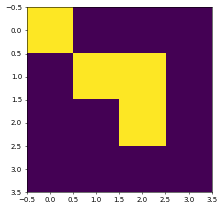

In [33]:
obs = env.reset()
done = False
while not done:
    action = alg._policy(
                    obs=obs,
                    context=None
                )
    obs, reward, done, info = env.step(action)
env.render() 

In [10]:
np.mean(alg._evaluate(env)[0])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


1.741023840304485e-05